In [1]:
import jax
import jax.numpy as np
import numpy as onp
import pylab as pl
import itertools

from jax import vmap, grad, random, jit
from jax.ops import index_update, index

from jax.experimental import stax, optimizers
from jax.experimental.stax import Tanh, Dense, BatchNorm, Conv, ConvTranspose, Dense, Flatten, Relu, LogSoftmax, elementwise

from jax.nn.initializers import glorot_normal, normal, zeros, glorot_uniform
from jax.experimental import optimizers
from tqdm.notebook import trange, tqdm
from functools import partial
from matplotlib import pyplot as plt

from scipy.integrate import odeint
import scipy.io

from jax.nn import sigmoid

In [2]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
import torchvision as thv

# Q1 CNN

In [3]:
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)
train_X_data = np.array(train.data.numpy())
train_Y_data = np.array(train.targets.numpy())

x_train = np.expand_dims(np.vstack((train_X_data[np.where(train_Y_data == i)][:750] for i in range(10))), 3) / 255.
y_train = np.hstack((train_Y_data[np.where(train_Y_data == i)][:750] for i in range(10)))

x_test = np.expand_dims(np.vstack((train_X_data[np.where(train_Y_data == i)][750:1000] for i in range(10))), 3) / 255.
y_test = np.hstack((train_Y_data[np.where(train_Y_data == i)][750:1000] for i in range(10)))

In [4]:
# Architecture
init_fun, conv_net = stax.serial(stax.Conv(6, (5, 5), (1, 1), padding="SAME"),
                                 stax.Relu, stax.MaxPool((2, 2), (2, 2)),
                                 stax.Conv(12, (5, 5), (1, 1), padding="SAME"),
                                 stax.Relu, stax.MaxPool((2, 2), (2, 2)),
                                 stax.Conv(24, (5, 5), (1, 1), padding="SAME"),
                                 stax.Relu, stax.Flatten,
                                 stax.Dense(256), stax.Relu, stax.Dense(128), 
                                 stax.Relu, stax.Dense(64), stax.Relu, 
                                 stax.Dense(10), stax.Softmax)

# Cross entropy, y is index of label NOT one hot.
def loss(params, batch):
    X, y = batch
    return -np.log(conv_net(params, X)[np.arange(y.shape[0]), y]).mean()

def accuracy(params, batch):
    X, y = batch

    y_pred = np.argmax(conv_net(params, X),1)

    return (y_pred == y).sum() / X.shape[0]


lr = optimizers.exponential_decay(1e-3, decay_rate = 0.99, decay_steps = 500)
opt_init, opt_update, get_params = optimizers.adam(lr)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)

    return opt_update(i, g, opt_state)


In [5]:
key = random.PRNGKey(1)
_, init_params = init_fun(key, (7500, 28, 28, 1))
opt_state = opt_init(init_params)

num_epoch = 5
batch_size = 200

epoch_key = random.split(key, num_epoch)

nIter = x_train.shape[0] // batch_size

for i in range(num_epoch):
    perm_idx = random.permutation(epoch_key[i], np.arange(x_train.shape[0]))
    epoch_x_data = x_train[perm_idx]
    epoch_y_data = y_train[perm_idx]

    for j in range(nIter):
        batch_x_data = epoch_x_data[j * batch_size : (j + 1) * batch_size]
        batch_y_data = epoch_y_data[j * batch_size : (j + 1) * batch_size]

        opt_state = step(i * nIter + j + 1, opt_state, (batch_x_data, batch_y_data))

    params = get_params(opt_state)
    print('Epoch : ', i + 1, 'Training acc. : ', accuracy(params, (x_train, y_train)), 'Test acc. : ', accuracy(params, (x_test, y_test)))
    
    


Epoch :  1 Training acc. :  0.85186666 Test acc. :  0.8392
Epoch :  2 Training acc. :  0.9152 Test acc. :  0.89800006
Epoch :  3 Training acc. :  0.9432 Test acc. :  0.9268001
Epoch :  4 Training acc. :  0.96173334 Test acc. :  0.94400007
Epoch :  5 Training acc. :  0.9677333 Test acc. :  0.94760007


# Q2 LSTM

In [6]:
key = random.PRNGKey(0)
def VDP(p, t):
  x, y = p
  dx = 5*(x-(x**3)/3-y)
  dy = x/5
  return (dx, dy)

In [7]:
y0 = np.array((0.1, 0.5))
t = np.linspace(0, 60, 2000)

y = odeint(VDP, y0, t)

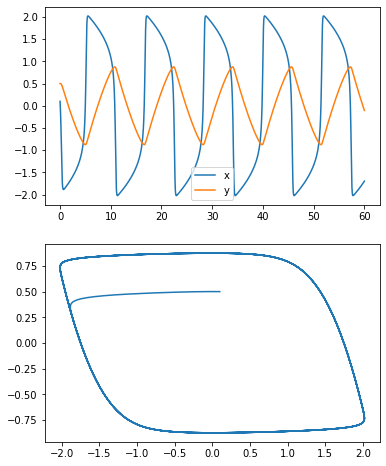

In [8]:
plt.figure(figsize = (6, 8))
plt.subplot(2,1,1)
plt.plot(t, y[:, 0], label = 'x')
plt.plot(t, y[:, 1], label = 'y')
plt.legend()
plt.subplot(2,1,2)
plt.plot(y[:, 0], y[:, 1])
plt.show()
plt.close()

In [9]:
def LSTM(in_dim, out_dim, hidden_dim, num_lags):
    '''
        LSTM for time series
    '''
    # Define init function
    def init(rng_key):
        # Define methods for initializing the weights
        def glorot_normal(rng_key, size):
          in_dim = size[0]
          out_dim = size[1]
          glorot_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
          return glorot_stddev*random.normal(rng_key, (in_dim, out_dim))
        # Inputs
        Uo = glorot_normal(rng_key, (in_dim, hidden_dim))
        Us = glorot_normal(rng_key, (in_dim, hidden_dim))
        Ui = glorot_normal(rng_key, (in_dim, hidden_dim))
        Uf = glorot_normal(rng_key, (in_dim, hidden_dim))
        bo = np.zeros(hidden_dim)
        bs = np.zeros(hidden_dim)
        bi = np.zeros(hidden_dim)
        bf = np.zeros(hidden_dim)
        # Transition dynamics
        Wo = np.eye(hidden_dim)
        Ws = np.eye(hidden_dim)
        Wi = np.eye(hidden_dim)
        Wf = np.eye(hidden_dim)
        # Outputs
        V = glorot_normal(rng_key, (hidden_dim, out_dim))
        c = np.zeros(out_dim)
        return (Uo, bo, Wo, Us, bs, Ws, Ui, bi, Wi, Uf, bf, Wf, V, c)
    # Define apply function
    def apply(params, input):
        Uo, bo, Wo, Us, bs, Ws, Ui, bi, Wi, Uf, bf, Wf, V, c = params
        H = np.zeros((input.shape[1], hidden_dim))
        S = np.zeros((input.shape[1], hidden_dim))
        for i in range(num_lags):
            O = sigmoid(H@Wo + input[i,:,:]@Uo + bo)
            S_tilde = np.tanh(H@Ws + input[i,:,:]@Us + bs)
            it = sigmoid(H @ Wi + input[i,:,:]@Ui + bi)
            f = sigmoid(H@Wf + input[i,:,:]@Uf + bf)
            S = f * S + it * S_tilde
            H = O * np.tanh(S)      
        H = H@V + c
        return H
    return init, apply

In [10]:
def create_lags(data, L):
    N = data.shape[0] - L
    D = data.shape[1]
    X = np.zeros((L, N, D))
    Y = np.zeros((N, D))
    for i in range(0,N):
        X = index_update(X, index[:,i,:], data[i:(i+L), :])
        Y = index_update(Y, index[i,:], data[i+L, :])
    return X, Y



In [11]:
data_X, data_Y = create_lags(y[:1333,:], 8)

In [12]:
init_fn, apply_fn = LSTM(2, 2, 20, 8)
apply_fn = jit(apply_fn)
init_params = init_fn(key)
opt_init, opt_update, get_params = optimizers.adam(1e-3)

def loss(params, batch):
    X, y = batch
    y_pred = apply_fn(params, X)

    return np.mean((y_pred - y)**2)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)

    return opt_update(i, g, opt_state)

In [13]:
opt_state = opt_init(init_fn(key))

pbar = trange(20000)
# Training
for i in pbar:
    key, _ = random.split(key)

    batch_idx = random.choice(key, np.arange(data_X.shape[1]), (128,))

    batch = (data_X[:, batch_idx], data_Y[batch_idx])

    opt_state = step(i, opt_state, batch)

    if i % 100 == 0:
        pbar.set_postfix({'Loss' : loss(get_params(opt_state), batch)})

In [14]:
opt_params = get_params(opt_state)
ys_pred = [*y[1333 - 8 : 1333]]

In [15]:
# Prediction
for j in trange(666):
    y_pred = apply_fn(opt_params, np.expand_dims(np.array(ys_pred[-8:]), 1))
    ys_pred.append(y_pred[0])

ys_pred = np.array(ys_pred)

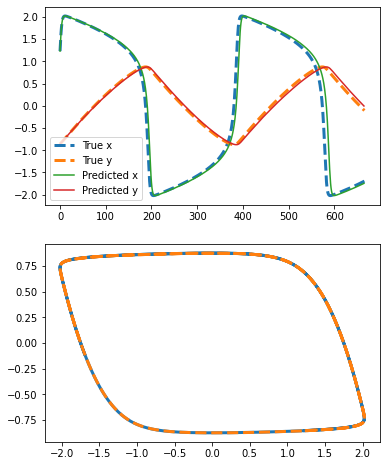

In [16]:
plt.figure(figsize = (6, 8))
plt.subplot(2,1,1)
plt.plot(y[1333:, 0], label = 'True x', linestyle = '--', linewidth = 3)
plt.plot(y[1333:, 1], label = 'True y', linestyle = '--', linewidth = 3)

plt.plot(ys_pred[-666:, 0], label = 'Predicted x')
plt.plot(ys_pred[-666:, 1], label = 'Predicted y')
plt.plot()
plt.legend()
plt.subplot(2,1,2)
plt.plot(y[1333:, 0], y[1333:, 1], label = 'True', linewidth = 3)
plt.plot(*ys_pred[-666:].T, linestyle = '--', label = 'Predicted', linewidth = 3)
plt.show()
plt.close()

In [17]:
print('The relative L2 is ', np.linalg.norm(ys_pred[-666:] - y[1333:-1]) / np.linalg.norm(y[1333:-1]))

The relative L2 is  0.15562485


# Q3 Burgers with PINNs

In [18]:
def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [19]:
layers = [2, 20, 20, 20, 20, 20, 1]
init_fn, apply_fn = MLP(layers)

In [20]:
init_params = init_fn(key)

In [21]:
# Scalar output
def net_u(params, xt):
    return apply_fn(params, xt)[0]
# Scalar residual
def net_r(params, xt):
    ux, ut = grad(net_u, argnums=1)(params, xt)
    # Auxillary function for fixed t
    u_x = lambda x: net_u(params, np.array((x, xt[1])))

    uxx = grad(grad(u_x))(xt[0])
    return ut + net_u(params, xt) * ux - 0.01 / np.pi * uxx
def loss(params, batch):
    (xt_t, xt_0, xt_r), (u_t, u_0) = batch

    u_t_pred = vmap(net_u, in_axes=[None, 0])(params, xt_t)
    u_0_pred = vmap(net_u, in_axes=[None, 0])(params, xt_0)

    u_r_pred = vmap(net_r, in_axes=[None, 0])(params, xt_r)

    return np.mean((u_t_pred - u_t)**2) + np.mean((u_0_pred - u_0)**2) + np.mean(u_r_pred**2)

# lr = optimizers.exponential_decay(1e-3, decay_rate = 0.99, decay_steps = 100)
lr = 1e-3
opt_init, opt_update, get_params = optimizers.adam(lr)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)

    return opt_update(i, g, opt_state)

In [22]:
# Collocation points for residual loss.
num_res = 10000
_, key = random.split(key)
x_r = random.uniform(key, (num_res, ), minval = -1, maxval = 1)

_, key = random.split(key)
t_r = random.uniform(key, (num_res, ), minval = 0, maxval = 1)

xt_r = np.array((x_r, t_r)).T
print(xt_r.shape)

num_boundary = 100
## Boundary points for initial condition loss.
_, key = random.split(key)
x_0 = random.uniform(key, (num_boundary, ), minval = -1, maxval = 1)

xt_0 = np.array((x_0, np.zeros_like(x_0))).T
print(xt_0.shape)
u_0 = -np.sin(np.pi * xt_0[:, 0])

# Boundary points for boundary condition loss.
_, key = random.split(key)
t_t = random.uniform(key, (num_boundary * 2, ), minval = 0, maxval = 1)

x_t = np.concatenate((-1. * np.ones((num_boundary, )), 1. * np.ones((num_boundary, ))))

xt_t = np.array((x_t, t_t)).T
print(xt_t.shape)
u_t = np.zeros((num_boundary * 2,))

(10000, 2)
(100, 2)
(200, 2)


In [23]:
nIter = 20000
pbar = trange(nIter)
res_batch_size = 10000
train_key = random.split(key, nIter)

opt_state = opt_init(init_params)
batch = ((xt_t, xt_0, xt_r), (u_t, u_0))

for i in pbar:
    
    opt_state = step(i, opt_state, batch)
    if i % 50 == 0:
        pbar.set_postfix({'Loss' : loss(get_params(opt_state), batch)})



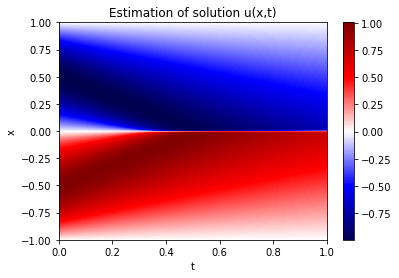

In [24]:
t_min, t_max  = 0, 1
x_min, x_max  = -1, 1
resolution = 500
tt, xx = np.meshgrid(np.linspace(t_min, t_max, (t_max-t_min)*resolution),
                      np.linspace(x_min, x_max, (x_max-x_min)*resolution))
zz = vmap(net_u, in_axes=(None, 0))(get_params(opt_state), np.array((xx.ravel(), tt.ravel())).T)
zz = zz.reshape(tt.shape)
plt.pcolormesh(tt, xx, zz, cmap='seismic')
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.title('Estimation of solution u(x,t)')
plt.show()

In [25]:
!wget https://github.com/PredictiveIntelligenceLab/PINNs/blob/master/appendix/Data/burgers_shock.mat?raw=true
!mv burgers_shock.mat\?raw\=true burgers_shock.mat

--2021-05-01 02:03:21--  https://github.com/PredictiveIntelligenceLab/PINNs/blob/master/appendix/Data/burgers_shock.mat?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/PredictiveIntelligenceLab/PINNs/raw/master/appendix/Data/burgers_shock.mat [following]
--2021-05-01 02:03:21--  https://github.com/PredictiveIntelligenceLab/PINNs/raw/master/appendix/Data/burgers_shock.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PredictiveIntelligenceLab/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2021-05-01 02:03:21--  https://raw.githubusercontent.com/PredictiveIntelligenceLab/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199

In [26]:
from scipy import io
data = io.loadmat('burgers_shock.mat')

exact = np.real(data['usol']).T

xs = np.linspace(-1., 1., 256)
ts = np.linspace(0., 1., 100)


tt, xx = np.meshgrid(ts, xs)
zz = vmap(net_u, in_axes=(None, 0))(get_params(opt_state), np.array((xx.ravel(), tt.ravel())).T)
predictions = zz.reshape(tt.shape).T

error = np.linalg.norm(exact - predictions, 2)/np.linalg.norm(exact, 2)
print('Relative L2 prediction error: %e' % (error))

Relative L2 prediction error: 3.007837e-02
